## Introduction
This tutorial will give an introduction to time series analysis. There are many types of data that are time dependent including finances, weather, and speech, to name a few. For example, we may want to predict what the stock market will look like tomorrow, understand weather patterns, or classify the parts of speech of a text. However, we cannot analyze this data using usual regression techniques. Regression analysis does not take into account that the data depends on the data that came before it. We need new techniques to understand time dependent data - this is where time series analysis comes in.

## Tutorial Content
In this tutorial, we will cover basic concepts from time series analysis. To help us we will use the python library [PyFlux](http://pyflux.readthedocs.io/en/latest/index.html). Specifically, we will be analyzing the average temperature in Pittsburgh every day from 1/1/15 to 12/31/17 as recorded by [NOAA](https://www.ncdc.noaa.gov/cdo-web/datasets/GHCND/locations/CITY:US420016/detail).

Topics covered include:
 - [Installing PyFlux](#Installing-PyFlux)
 - [Loading the Data](#Loading-the-Data)
 - [Exploratory Data Analysis](#Exploratory-Data-Analysis)
 - [Stationarity](#Stationarity)
     - [Definition](#Definition)
     - [Testing Stationarity](#Testing-Stationarity)
     - [Transforming Data to be Stationary](#Transforming-Data-to-be-Stationary)
 - [Parametric Modeling](#Parametric-Modeling)
 - [Evaluating the Model](#Evaluating-the-Model)
 - [Summary and References](#Summary-and-References)

## Installing PyFlux
To install PyFlux use the following command:

    $ pip install pyflux

For this tutorial will will also need to install a few other libraries

In [1]:
import csv
import pandas as pd
import datetime
import matplotlib
import pyflux as pf
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (10.0, 5.0) 
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from IPython.display import Image

Now it is time to load the data!

## Loading the Data

In [2]:
def make_pitt_weather_dataframe(filepath):
    l = []
    with open(filepath, 'r', encoding = 'utf-8') as csvfile:
        data = csv.reader(csvfile, delimiter=',', quotechar='"')
        header = next(data, None)
        for row in data:
            #make the date a datetime object
            row[2] = pd.to_datetime(row[2]) 
            #make average temperature a float 
            row[3] = float(row[3])
            #append ........
            l += [tuple(row)] 
    return(pd.DataFrame(l, columns = header))

data = make_pitt_weather_dataframe("Pitt_weather_data.csv")

Check that the data has been properly loaded.

In [3]:
print(data.dtypes)
data.head()

STATION            object
NAME               object
DATE       datetime64[ns]
TAVG              float64
dtype: object


,STATION,NAME,DATE,TAVG
0,USW00094823,"PITTSBURGH ASOS, PA US",2015-01-01,25.0
1,USW00094823,"PITTSBURGH ASOS, PA US",2015-01-02,31.0
2,USW00094823,"PITTSBURGH ASOS, PA US",2015-01-03,32.0
3,USW00094823,"PITTSBURGH ASOS, PA US",2015-01-04,53.0
4,USW00094823,"PITTSBURGH ASOS, PA US",2015-01-05,24.0


Indeed it has! The temperatures look typical of January in Pittsburgh (too cold), and the date and average temperature have been succesfully converted to datetime and float.

## Exploratory Data Analysis

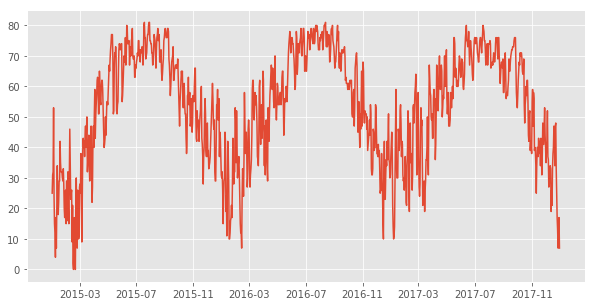

In [4]:
#Plot the data
plt.plot(data.DATE, data.TAVG)
plt.show()

Looking at the plot above we see, unsurprisingly, that the data has a "cyclic" pattern. We use the word cyclic in quotes because cyclic has a specific meaning in time series analysis. What we are actually seeing is a seasonal trend. [Seasonality is distinct from cycles](https://robjhyndman.com/hyndsight/cyclicts/) because seasonal data repeats in specific time intervals, while cycles can vary in length of time. A slightly less obvious observation we can make looking at this plot is an increased variance in average daily temperature during the winter months. Before we can begin to analyze the data, we need to make it stationary, i.e. remove seasonality and other trends. 

## Stationarity



### Definition
Simply put, [stationary data](https://en.wikipedia.org/wiki/Stationary_process) does not show a change in mean, variance, or autocorrelation over time. In mathematical terms, a stationary process is one where the joint probability distribution of the data remains unchanged over time, which would imply the data has constant mean, variance, and other statistical properties of a distribution.

### Testing Stationarity

There are many ways to test stationarity, but we will just be looking at the [Dickey Fuller test](https://www.youtube.com/watch?v=2GxWgIumPTA). 

First consider the model:
$$X_t = \rho X_{t-1} + \epsilon_t$$

Where $\epsilon_t \sim N(0, \sigma^2)$ for all $t$.

In this model the current time is dependent on the previous time, which is dependent on the time before it and so on all the way until time $t = 0$. In order for this process to be stationary we want the mean (expectation) to be the same regardless of time so we take the expected value of both sides.

$$\mathbb{E}\left[X_t \right]= \mathbb{E}\left[\rho X_{t-1} + \epsilon_t\right]$$
$$\Leftrightarrow \mathbb{E}\left[X_t \right]= \rho\mathbb{E}\left[X_{t-1}\right] + \mathbb{E}\left[\epsilon_t\right]$$
$$\Leftrightarrow \mathbb{E}\left[X_t \right]= \rho\mathbb{E}\left[X_{t-1}\right]$$

Since we are assuming the process is stationary, $\mathbb{E}[X_t] = \mathbb{E}[X_{t-1}]$ we can replace $\mathbb{E}[X_{t-1}]$ with $\mathbb{E}[X_t]$.

$$\mathbb{E}\left[X_t \right]= \rho\mathbb{E}\left[X_t\right]$$

In order for the left and right hand sides to be equal $\mathbb{E}[X_t]$ must be $0$ for all $t$.

We also want the variance to be constant. Taking the variance of both sides we get

$$V\left[X_t \right]= V\left[\rho X_{t-1} + \epsilon_t\right]$$
$$\Leftrightarrow V\left[X_t \right]= \rho^2 V\left[X_{t-1}\right] + V\left[\epsilon_t\right] + 2Cov[X_{t-1}, \epsilon_t]$$
$$\Leftrightarrow V\left[X_t \right]= \rho^2 V\left[X_{t-1}\right] + \sigma^2$$

Again, since we are assuming the process is stationary, $V[X_t] = V[X_{t-1}]$ we can replace $V[X_{t-1}]$ with $V[X_t]$.

$$\Leftrightarrow V\left[X_t \right]= \rho^2 V\left[X_t\right] + \sigma^2$$
$$\Leftrightarrow (1-\rho^2) V\left[X_t \right]= \sigma^2$$
$$\Leftrightarrow V\left[X_t \right]= \frac{\sigma^2}{(1-\rho^2)}$$

Notice, if $|\rho| = 1$ the variance is undefined, meaning it is not possible for the data to be stationary. The Dickey-Fuller test, essentially, tests how confident we are that $\rho < 1$. Specifically, we have that the null hypothesis is $\rho = 1$ and the alternative hypothesis is $\rho < 1$. We ignore the case where $\rho >1$ as we would almost never encounter this type of dataset in life. 

So how do we test this? As with many statistical tests we look at a distribution we believe describes the random variable. In this case, that distibution is the Dickey-Fuller Distribution (what a surprise!). However, in order to use this distribution we need to transform our model slightly.

$$X_t = \rho X_{t-1} + \epsilon_t$$

Subtract $X_{t-1}$ from both sides.

$$X_t - X_{t-1} = (1 - \rho)X_{t-1} + \epsilon_t$$

Let $X_t - X_{t-1} = \Delta X_t$ and $(1 - \rho) = \delta$

$$\Delta X_t = \delta X_{t-1} + \epsilon_t$$

In this new form $|\rho| < 1$ is the same as $|\delta| < 0$, but how do we estimate $\delta$? We use something we know well - regression analysis! Once we get our estimate of $\delta$, $\hat{\delta}$, we can calculate the [t-statistic](https://en.wikipedia.org/wiki/T-statistic) for the estimate, which in linear regression is $\hat{\delta}$ divided by the standard error of $\hat{\delta}$. The reason we cannot simply use the t-statistic we computed is because, as mentioned in the [introduction](#Introduction), time dependent data does not follow the usual regression rules, and similarly does not have t distributed coefficients. Finally, we compare the t-statistic to some critical value of the Dickey Fuller distribution, $DF_{crit}$, usually the quantile corresponding to the confidence level at which we wish to test. If $t < DF_{crit}$ then we reject the null hypothesis and conclude that the data is, in fact, stationary.

The general model for a Dickey Fuller test is:
$$\Delta X_t = \alpha + \gamma t + \delta X_{t-1} + \sum_{i=1}^p \beta_i\Delta X_{t-i} + \epsilon_t$$

When we use the general model this is called the augmented Dickey Fuller test. As you can see, the model we examined is actually just a special case of the general model where $\alpha = \gamma = \beta_i = 0$. The null and alternative hypotheses are the same for the general model as the one we looked at. This test is more complicated, not just because of the increased number of terms, but also because we now have to [choose the number of delta terms](http://www.statisticshowto.com/adf-augmented-dickey-fuller-test/) to include. One way the number of delta terms is chosen is by using th AIC score. This is what we will use in this tutorial.

### Transforming Data to be Stationary

Now that we know how to test our data to see if its stationary, let's actually do it!

In [5]:
p_val_no_transform = adfuller(data.TAVG, autolag = "AIC")[1]
print(p_val_no_transform)

0.416492709383


The function adfuller rather than returning an acception or rejection of the null hypothesis for some critical value, instead returns the p-value corresponding to the quantile of the Dickey Fuller distribution. Essentially, the p-value tells you how confident we are in rejecting the null hypothesis. In the case above, we are not confident enough to say $\delta < 0$. Usually in statistics, we want the p-value to be 0.05 or less.

So now what? One of the most common ways to make data stationary is through [differencing](http://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/), which is what we will do in this tutorial, however, there are other methods, such as taking the log of the data. Let's begin by looking at a first difference.

A first difference is the difference between all the adjacent data points in the original set. In our case, this is the difference between all the data points which are one day apart. In code this looks like:

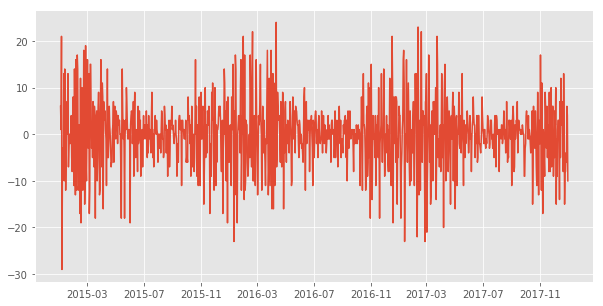

In [6]:
data['first_diff'] = data.TAVG - data.TAVG.shift(1)
plt.plot(data.DATE[1:], data.first_diff[1:])
plt.show()

Just from a first glance it is easy to see that this is much better than the original data set. The mean looks constant and approximately zero. The variance still appears to be non-constant. Let's test this using the augmented Dicky-Fuller test. 

In [7]:
p_val_first_diff = adfuller(data.first_diff[1:], autolag = "AIC")[1]
print("Augmented Dickey Fuller p-value: %s" %str(p_val_first_diff))

Augmented Dickey Fuller p-value: 1.77746607152e-18


This is an extremely small p-value and a huge difference from the untransformed data set. We are highly confident that this data set is indeed stationary.

However, this is not the only difference we can take. As noted in the exploratory data analysis, there appears to be a seasonal trend to the data. The period for one season, in this case, is one year so we take a difference of 365.

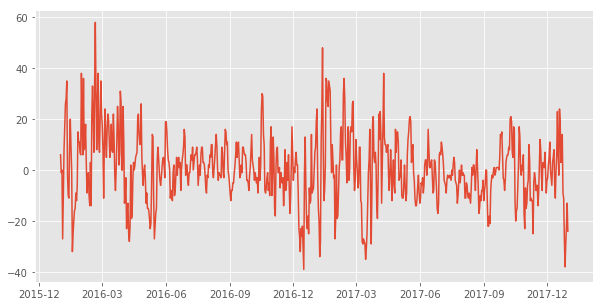

Augmented Dickey Fuller p-value: 2.53640394014e-15


In [8]:
data['seasonal_diff'] = data.TAVG - data.TAVG.shift(365)
plt.plot(data.DATE[365:], data.seasonal_diff[365:])
plt.show()

p_val_seasonal_diff = adfuller(data.seasonal_diff[365:], autolag = "AIC")[1]
print("Augmented Dickey Fuller p-value: %s" %str(p_val_seasonal_diff))

Although this p-value is small enough to reject the null hypothesis that the data is non-stationary, it is not as small as the p-value for the first differenced data. We can combine these two differences to take what is called a seasonal first difference, where we take a seasonal difference of the first differenced data. 

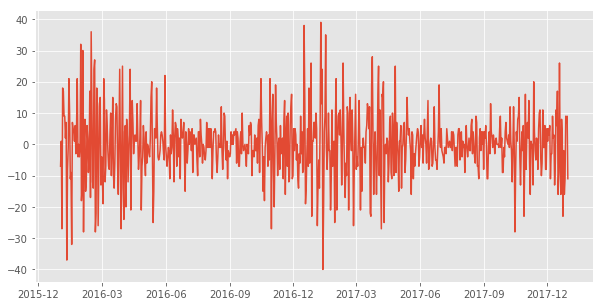

Augmented Dickey Fuller p-value: 5.74603190886e-18


In [9]:
data['seasonal_first_diff'] = data.first_diff - data.first_diff.shift(365)
plt.plot(data.DATE[366:], data.seasonal_first_diff[366:])
plt.show()

p_val_seasonal_first_diff = adfuller(data.seasonal_first_diff[366:])[1]
print("Augmented Dickey Fuller p-value: %s" %str(p_val_seasonal_first_diff))

Again, we see that the p-value for the seasonal first difference is small enough to reject the null hypothesis, but it is not as small as the p-value for the first difference. They are, however, the same order of magnitude, unlike the seasonal difference, which was a few orders of magnitude larger.

Now that we have stationary data it is time to fit a model!

## Parametric Modeling

Just like with regression analysis, there are both parametric and non-parametric ways to fit a model to the data. For this tutorial, we are going to focus on parametric modeling, specifically [ARIMA models](https://people.duke.edu/~rnau/411arim.htm). ARIMA stands for Auto Regressive Integrated Moving Average and is a very general model since it can fit auto regressive, integrated, and moving average models, or a combination of the three.

We will be using the PyFlux function ARIMA to fit our model. For arguments, the function takes in:

- data - the data for which you would like to fit a model
- ar - the number of autoregressive terms to use
- integ - the number of times to difference the data
- ma - the number of moving average terms to use
- target - the column to use from the given data frame

Before we can fit this model we need to know what our arguments for ar, integ, and ma should be. For this, we need to look at the auotocorrelation function (acf) and the partial autocorrelation function (pacf) of our data. Acf measures the correlation of the data to itself after shifting, pacf does the same thing, but it also controls for all the previous shifts. We will use the seasonal first differenced data, since we need to account for seasonality in our model. 

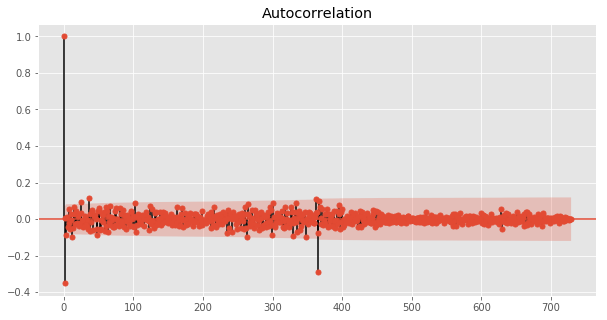

In [10]:
plot_acf(data.seasonal_first_diff[366:])

We ignore the spike at 0 in our analysis, since of course data would have an autocorrelation of 1 if there was no shifting. We see a spike at 1, so we will include 1 AR term to our model. Notice there is a second spike around 365, one year later.

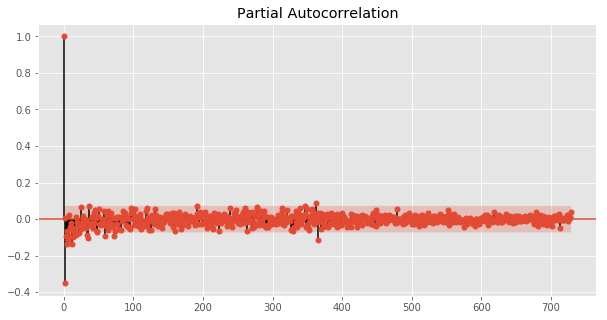

In [11]:
plot_pacf(data.seasonal_first_diff[366:])

The pacf also has a spike at one and nowehere else, confirming the we shoud use just 1 AR term.

In [12]:
#fit the model
model1 = pf.ARIMA(data=data[366:], ar=1, integ = 0, ma=0, target='seasonal_first_diff')
x1 = model1.fit("MLE")
x1.summary()

Normal ARIMA(1,0,0)                                                                                       
======================================================= ==================================================
Dependent Variable: seasonal_first_diff                 Method: MLE                                       
Start Date: 367                                         Log Likelihood: -2732.5343                        
End Date: 1095                                          AIC: 5471.0687                                    
Number of observations: 729                             BIC: 5484.8437                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 -0.0406    0.3804     -0.1066  0.9151   (-0.7862 | 0.7051)       
AR(1)                                

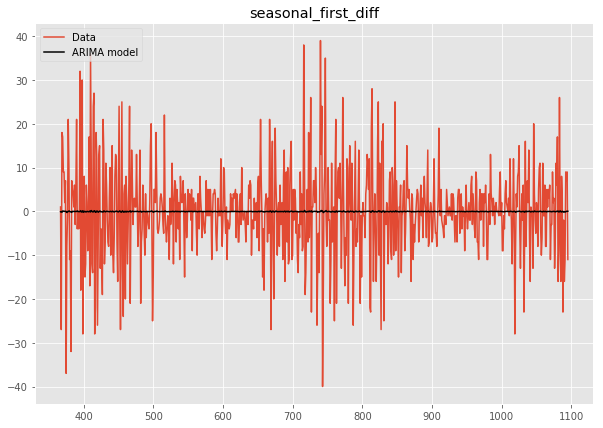

In [23]:
#plot the fitted values
model1.plot_fit()

Now it's time to test our model.

## Evaluating the Model

We can use weather data from this year to test with since we didn't use it to fit our model.

In [14]:
#Load the test data
test_data = make_pitt_weather_dataframe("Pitt_weather_test_data2018.csv")

In [15]:
#Confirm that the data loaded properly
print(data.dtypes)
test_data.head()

STATION                        object
NAME                           object
DATE                   datetime64[ns]
TAVG                          float64
first_diff                    float64
seasonal_diff                 float64
seasonal_first_diff           float64
dtype: object


,STATION,NAME,DATE,TAVG
0,USW00094823,"PITTSBURGH ASOS, PA US",2018-01-01,6.0
1,USW00094823,"PITTSBURGH ASOS, PA US",2018-01-02,8.0
2,USW00094823,"PITTSBURGH ASOS, PA US",2018-01-03,10.0
3,USW00094823,"PITTSBURGH ASOS, PA US",2018-01-04,15.0
4,USW00094823,"PITTSBURGH ASOS, PA US",2018-01-05,4.0


In [16]:
#undo the seasonal first differencing
def undo_seasonal_first_diff(preds, data, test_data, h):
    n = (len(data.TAVG)) - 1
    transformed_preds = []
    
    #how do we calculate TAVG from the predicted seasonal first differenc?
    #preds[i] = (TAVG[(n+i+1)-365] - TAVG[n+i-365]) - (TAVG[n+i+1] - TAVG[n+i])
    #we want to calculate TAVG[n+i+1] for i in range len(preds)
    #TAVG[n+i+1] = (TAVG[(n+i+1)-365] - TAVG[n+i-365]) - preds[i] + TAVG[n+i]
    
    for i in range(len(preds)):
        #case based on which data frame the temperature average is coming from
        
        #caluculate (TAVG[(n+i+1)-365] - TAVG[n+i-365])
        if i < 365:
            portion1 = data.TAVG.iloc[n+i-364] - data.TAVG.iloc[n+i-365]
        elif i == 365:
            portion1 = test_data.TAVG.iloc[i-365] - data.TAVG.iloc[n+i-365]
        else:
            portion1 = test_data.TAVG.iloc[i-365] - test_data.TAVG.iloc[i-366]
        
        #calculate TAVG[n+i]
        if i == 0:
            portion2 = data.TAVG.iloc[n]
        else:
            portion2 = test_data.TAVG.iloc[i-1]
        
        val = portion1 - preds.iloc[i][0] + portion2
        transformed_preds += [val]
        
    return transformed_preds

In [17]:
#caluculate the mean square error
def compute_mse(preds, data, test_data, h):
    sse = 0
    predictions = undo_seasonal_first_diff(preds, data, test_data, h)
    for i in range(h):
        error = predictions[i] - test_data.TAVG.iloc[i]
        sse += np.square(error)
    mse = sse/h
    return mse

In [18]:
#use the PyFlux function predict to get predictions
#we want to make the same number of predictions as the length of the test data
h = len(test_data.TAVG) 
preds1 = model1.predict(h = h)

In [19]:
#evaluate mse for model 1
print(compute_mse(preds1, data, test_data, h))

154.856316971


Let's compare this model to other models with different values for ar, integ, and ma.

In [20]:
#fit the models
#similar models
model2 = pf.ARIMA(data=data[366:], ar=2, integ = 0, ma=0, target='seasonal_first_diff')
x2 = model2.fit("MLE")
model3 = pf.ARIMA(data=data[366:], ar=1, integ = 0, ma=1, target='seasonal_first_diff')
x3 = model3.fit("MLE")
model4 = pf.ARIMA(data=data[366:], ar=2, integ = 0, ma=1, target='seasonal_first_diff')
x4 = model4.fit("MLE")
#very different model
model5 = pf.ARIMA(data=data[366:], ar=10, integ = 1, ma=10, target='seasonal_first_diff')
x5 = model5.fit("MLE")

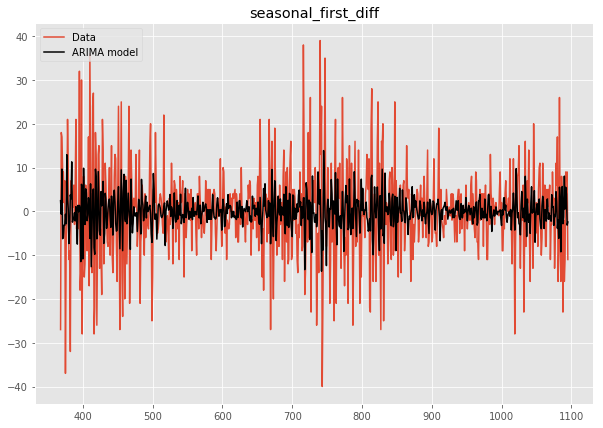

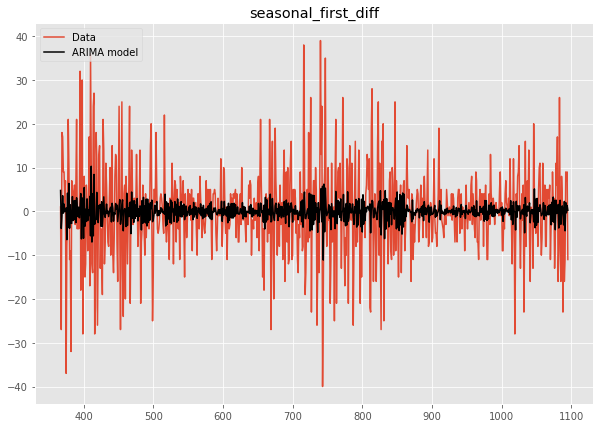

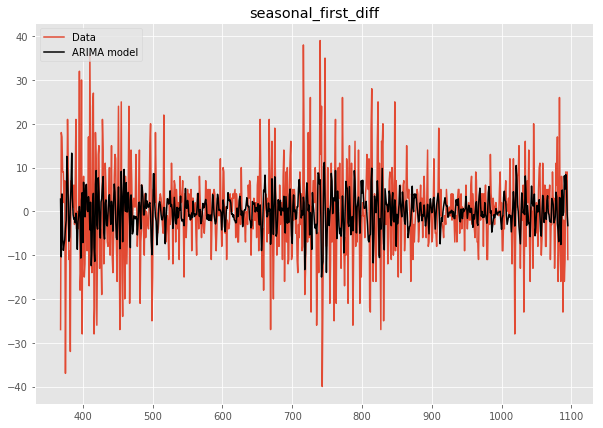

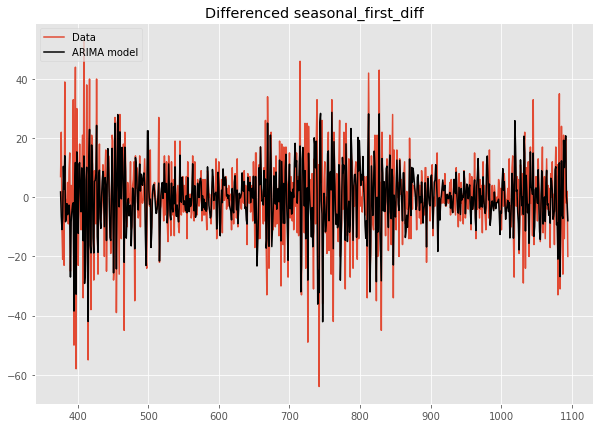

In [21]:
#plot the fits
model2.plot_fit()
model3.plot_fit()
model4.plot_fit()
model5.plot_fit()

In [22]:
def compare_mses(models, data, test_data, h):
    preds = None
    mse = 0
    for i in range(len(models)):
        preds = models[i].predict(h = h)
        mse = compute_mse(preds, data, test_data, h)
        print("model %d mse: %f" %(i+1, mse))

compare_mses([model1, model2, model3, model4, model5], data, test_data, h)

model 1 mse: 154.856317
model 2 mse: 155.076531
model 3 mse: 155.423693
model 4 mse: 155.581790
model 5 mse: 155.980627


The mse for model1 is smallest, however, we do not know the confidence intervals for these mses so we cannot say if there is a significantly different fit. For this we would need [cross validation](https://stats.stackexchange.com/questions/14099/using-k-fold-cross-validation-for-time-series-model-selection).

## Summary and References

After reading this tutorial you should have a basic idea for how to do a time series analysis. 

Other references I consulted not linked above:
- https://thingsolver.com/forecasting-with-arima/
- https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/
- http://www.statsoft.com/Textbook/Time-Series-Analysis#identification
- http://www.statsoft.com/Textbook/Time-Series-Analysis#fast
- https://machinelearningmastery.com/time-series-data-stationary-python/
- https://www.analyticsvidhya.com/blog/2015/12/complete-tutorial-time-series-modeling/
- http://www.real-statistics.com/time-series-analysis/stochastic-processes/dickey-fuller-test/
